## Module 1: Vanilla GAN

In [1]:
# Initialization of libraries
import torch
import torch.nn
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import random
from sklearn.mixture import GMM
device = torch.device('cuda')
%matplotlib inline

In [2]:
# defining parameters for the training
mb_size = 128 # Batch Size
Z_dim = 64  # Length of noise vector
X_dim = 1  # Input Length
h_dim = 128  # Hidden Dimension
lr = 1e-4    # Learning Rate

/home/shyam.nandan/.local/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)


(array([ 1.,  0.,  0., ...,  0.,  0.,  1.]),
 array([  0.00000000e+00,   5.00000000e-06,   1.00000000e-05, ...,
          9.99990000e-01,   9.99995000e-01,   1.00000000e+00]),
 <a list of 1 Patch objects>)

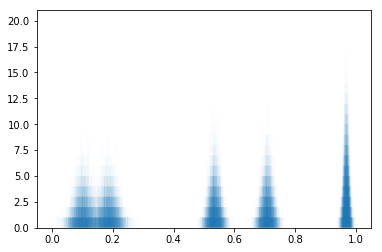

In [10]:
np.random.seed(1)
gmm = GMM(5)
gmm.means_ = np.array([[10], [20], [60], [80], [110]])
gmm.covars_ = np.array([[3], [3], [2], [2], [1]]) ** 2
gmm.weights_ = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

X = gmm.sample(200000)
data = X
data = (data - X.min())/(X.max()-X.min())
plt.hist(data, 200000, normed=False, histtype='stepfilled', alpha=1)

In [4]:
G = torch.nn.Sequential(
    torch.nn.Linear(Z_dim, h_dim),
    torch.nn.PReLU(),
    torch.nn.Linear(h_dim, h_dim),
    torch.nn.PReLU(),
    torch.nn.Linear(h_dim, X_dim),
    torch.nn.Sigmoid()
)

D = torch.nn.Sequential(
    torch.nn.Linear(X_dim, h_dim),
    torch.nn.LeakyReLU(0.2),
    torch.nn.Linear(h_dim, h_dim),
    torch.nn.LeakyReLU(0.2),
    torch.nn.Linear(h_dim, 1),
    torch.nn.Sigmoid()
)

G = G.cuda()
D = D.cuda()

Here, we will gather the parameters of the generator and the discriminator so that they can be given to the Adam optimizer to update the weights

In [5]:
G_solver = optim.Adam(G.parameters(), lr)
D_solver = optim.Adam(D.parameters(), lr)

ones_label = torch.ones(mb_size,1)
zeros_label = torch.zeros(mb_size,1)
loss = nn.BCELoss()
ones_label = ones_label.to(device)
zeros_label = zeros_label.to(device)

In [6]:
# Reset the gradients to zero
params = [G, D]
def reset_grad():
    for net in params:
        net.zero_grad()

 Now, we will start the actual training. The training alternates between updating the discriminator network's weights and updating the generator's weight.First, we update the discriminator's weight. We take a minibatch from the dataset and do a forward pass on the discriminator with the label '1'. Then, we feed noise into the generator and feed the generated images into the discriminator with the label '0'. We backpropagate the error and update the discriminator weights. To update the generator weights, we feed noise to the generator and feed the generated images into the discriminator with the label '1'. This error is backpropagated to update the weights of G.

In [7]:
data_index = 0
for it in range(198000):
    
    
    # ###
    if ((data_index + 1)*mb_size>len(data)):
        data_index = 0
    # ###
    #z = torch.randn(mb_size, Z_dim)
    z = torch.FloatTensor(mb_size, Z_dim).uniform_(-1, 1)
    X = torch.from_numpy(np.array(data[data_index*mb_size : (data_index + 1)*mb_size]))
    X = X.view(mb_size, 1)
    X = X.type(torch.FloatTensor)
    X = X.to(device)
    z = z.to(device)
    
    # Dicriminator forward-loss-backward-update
    #forward pass
    G_sample = G(z)
    D_real = D(X)
    D_fake = D(G_sample)
    
    # Calculate the loss
    D_loss_real = loss(D_real, ones_label)
    D_loss_fake = loss(D_fake, zeros_label)
    D_loss = D_loss_real + D_loss_fake

    # Calulate and update gradients of discriminator
    D_loss.backward()
    D_solver.step()

    # reset gradient
    reset_grad()

    # Generator forward-loss-backward-update
    
    #z = torch.randn(mb_size, Z_dim)
    z = torch.FloatTensor(mb_size, Z_dim).uniform_(-1, 1)
    z = z.to(device)
    G_sample = G(z)
    D_fake = D(G_sample)

    G_loss = loss(D_fake, ones_label)

    G_loss.backward()
    G_solver.step()

    # reset gradient
    reset_grad()
    data_index = data_index + 1
    # Print and plot every now and then
    if it % 10000 == 0:
        print('Iter-{}; D_loss: {}; G_loss: {}'.format(it, D_loss.data.cpu().numpy(), G_loss.data.cpu().numpy()))

Iter-0; D_loss: 1.3867483139; G_loss: 0.725483059883
Iter-10000; D_loss: 1.26860260963; G_loss: 0.834737956524
Iter-20000; D_loss: 1.3040766716; G_loss: 0.752894580364
Iter-30000; D_loss: 1.4255143404; G_loss: 0.811053931713
Iter-40000; D_loss: 1.25139951706; G_loss: 0.815014541149
Iter-50000; D_loss: 1.3731238842; G_loss: 0.705877661705
Iter-60000; D_loss: 1.37446188927; G_loss: 0.693414092064
Iter-70000; D_loss: 1.38193202019; G_loss: 0.727313995361
Iter-80000; D_loss: 1.38839507103; G_loss: 0.686470985413
Iter-90000; D_loss: 1.3618530035; G_loss: 0.739409983158
Iter-100000; D_loss: 1.39348912239; G_loss: 0.679715633392
Iter-110000; D_loss: 1.40462470055; G_loss: 0.682846009731
Iter-120000; D_loss: 1.33297848701; G_loss: 0.76128590107
Iter-130000; D_loss: 1.39791417122; G_loss: 0.725518107414
Iter-140000; D_loss: 1.36040127277; G_loss: 0.749178051949
Iter-150000; D_loss: 1.3797185421; G_loss: 0.701577544212
Iter-160000; D_loss: 1.3191344738; G_loss: 0.744646310806
Iter-170000; D_loss

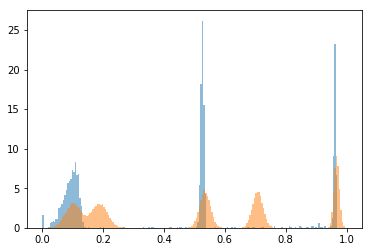

In [14]:
import numpy as np
final = np.zeros(1500*mb_size, dtype = float)
for i in range(1500):
    z = torch.FloatTensor(64, Z_dim).uniform_(-1, 1)
    z = z.to(device)
    l = G(z).cpu().detach().numpy()
    final[i*mb_size : ((i+ 1)*mb_size -1)] = l[0]
p1 = plt.hist(final, 200, normed=True, histtype='bar', alpha=0.5)
p2 = plt.hist(data, 200, normed=True, histtype='bar', alpha=0.5)

## Points to ponder
1. What happens if we don't do Xavier initialization?
2. What happens if we change the learning rate and other parameters?
3. What happens if we reduce the size of hidden layer to 10?
4. Is there any way to determine the class of the generated images by changing the input noise vector?
5. How long do we have to train the GAN to get good results? Can you plot the loss of the generator and discriminator and see if there is a correlation?
